In [1]:
!pip install pfhedge

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch

In [3]:
seaborn.set_style("whitegrid")

FONTSIZE = 18
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [5]:
torch.manual_seed(42)

if not torch.cuda.is_available():
    raise RuntimeWarning(
        "CUDA is not available. "
        "If you're using Google Colab, you can enable GPUs as: "
        "https://colab.research.google.com/notebooks/gpu.ipynb"
    )

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Default device:", DEVICE)

device(type='cuda', index=0)

In [6]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 50000
# How many times a model is updated in the experiment.
N_EPOCHS = 200

In [7]:
def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

## How to Use

### Prepare Instruments

We consider a `BrownianStock`, which is a stock following the geometric Brownian motion, and a `EuropeanOption` which is contingent on it.

We assume that the stock has a transaction cost given by `cost`.

In [8]:
from pfhedge.instruments import BrownianStock, EuropeanOption

stock = BrownianStock(cost=1e-3)
deriv = EuropeanOption(stock).to(DEVICE)

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [9]:
deriv

EuropeanOption(BrownianStock(...), maturity=8.22e-02)

### Create Your Hedger

We here use a multi-layer perceptron as our model.

In [10]:
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron

model = MultiLayerPerceptron()
hedger = Hedger(
    model, inputs=["log_moneyness", "expiry_time", "volatility", "prev_hedge"]
).to(DEVICE)

The `hedger` is also a [`Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module).

In [11]:
hedger

Hedger(
  features=['log_moneyness', 'expiry_time', 'volatility', 'prev_hedge'],
  (model): MultiLayerPerceptron(
    (0): LazyLinear(in_features=None, out_features=32, bias=True)
    (1): ReLU()
    (2): LazyLinear(in_features=None, out_features=32, bias=True)
    (3): ReLU()
    (4): LazyLinear(in_features=None, out_features=32, bias=True)
    (5): ReLU()
    (6): LazyLinear(in_features=None, out_features=32, bias=True)
    (7): ReLU()
    (8): LazyLinear(in_features=None, out_features=1, bias=True)
    (9): Identity()
  )
  (criterion): EntropicRiskMeasure()
)

In [12]:
history = hedger.fit(deriv, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=2.23127e-02: 100%|██████████| 200/200 [02:13<00:00,  1.50it/s]


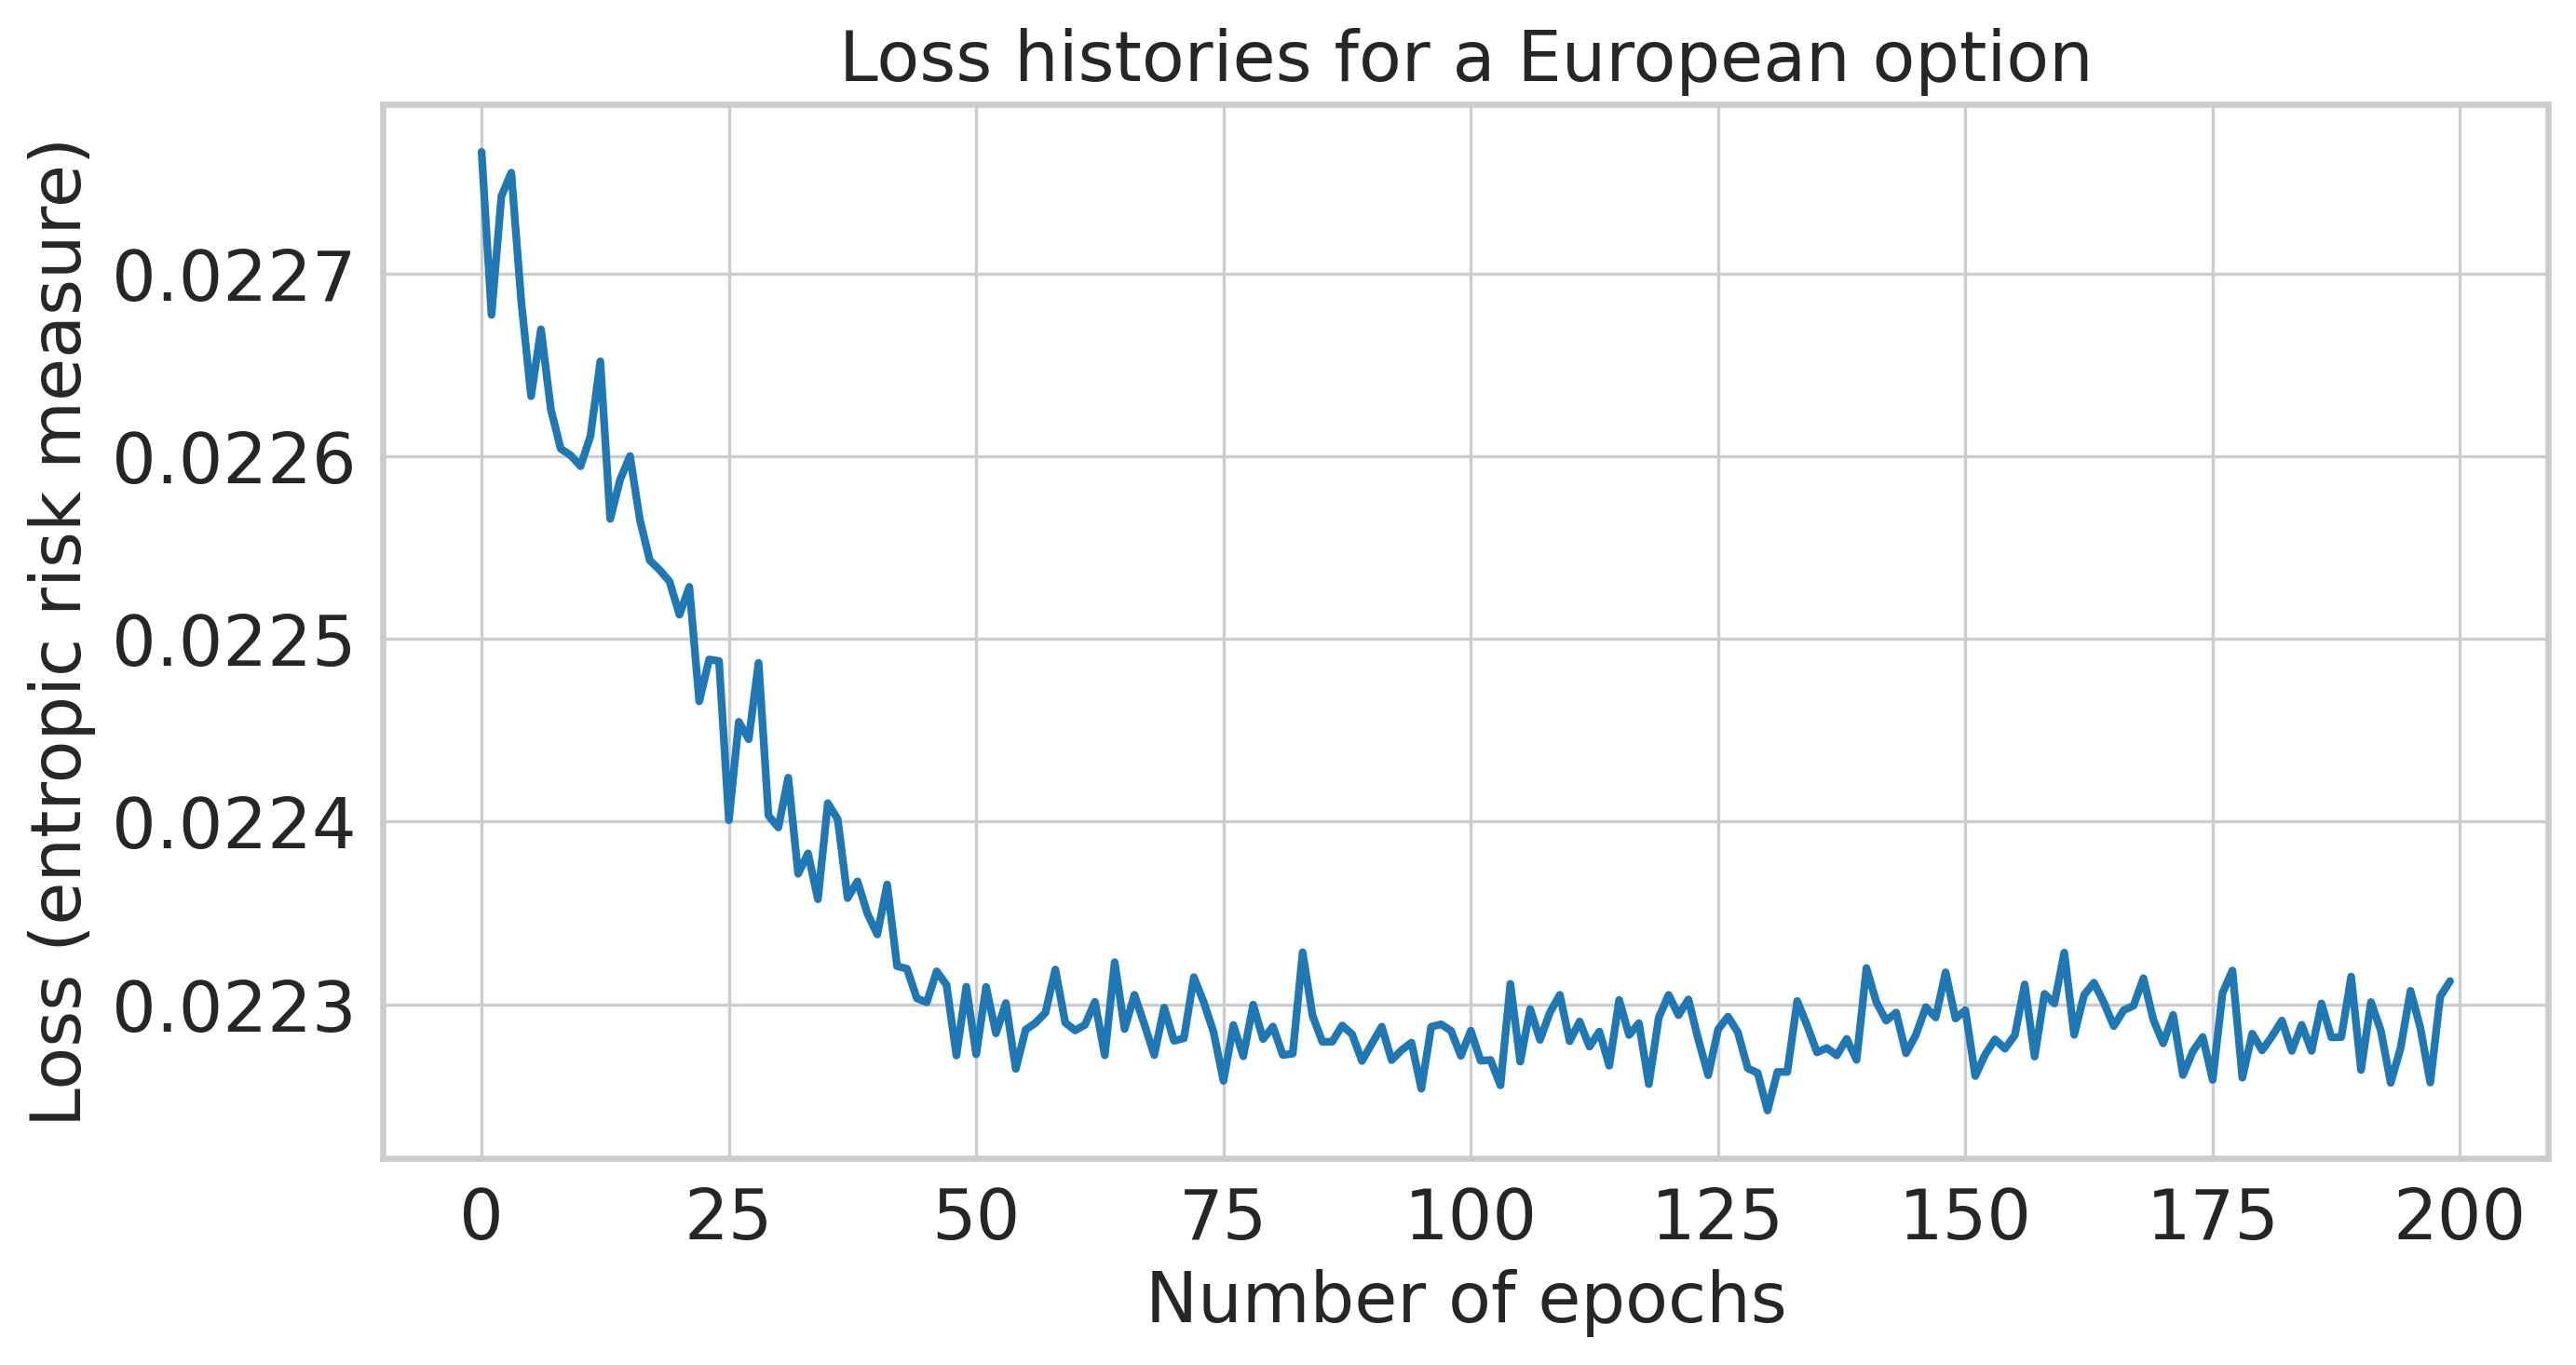

In [13]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

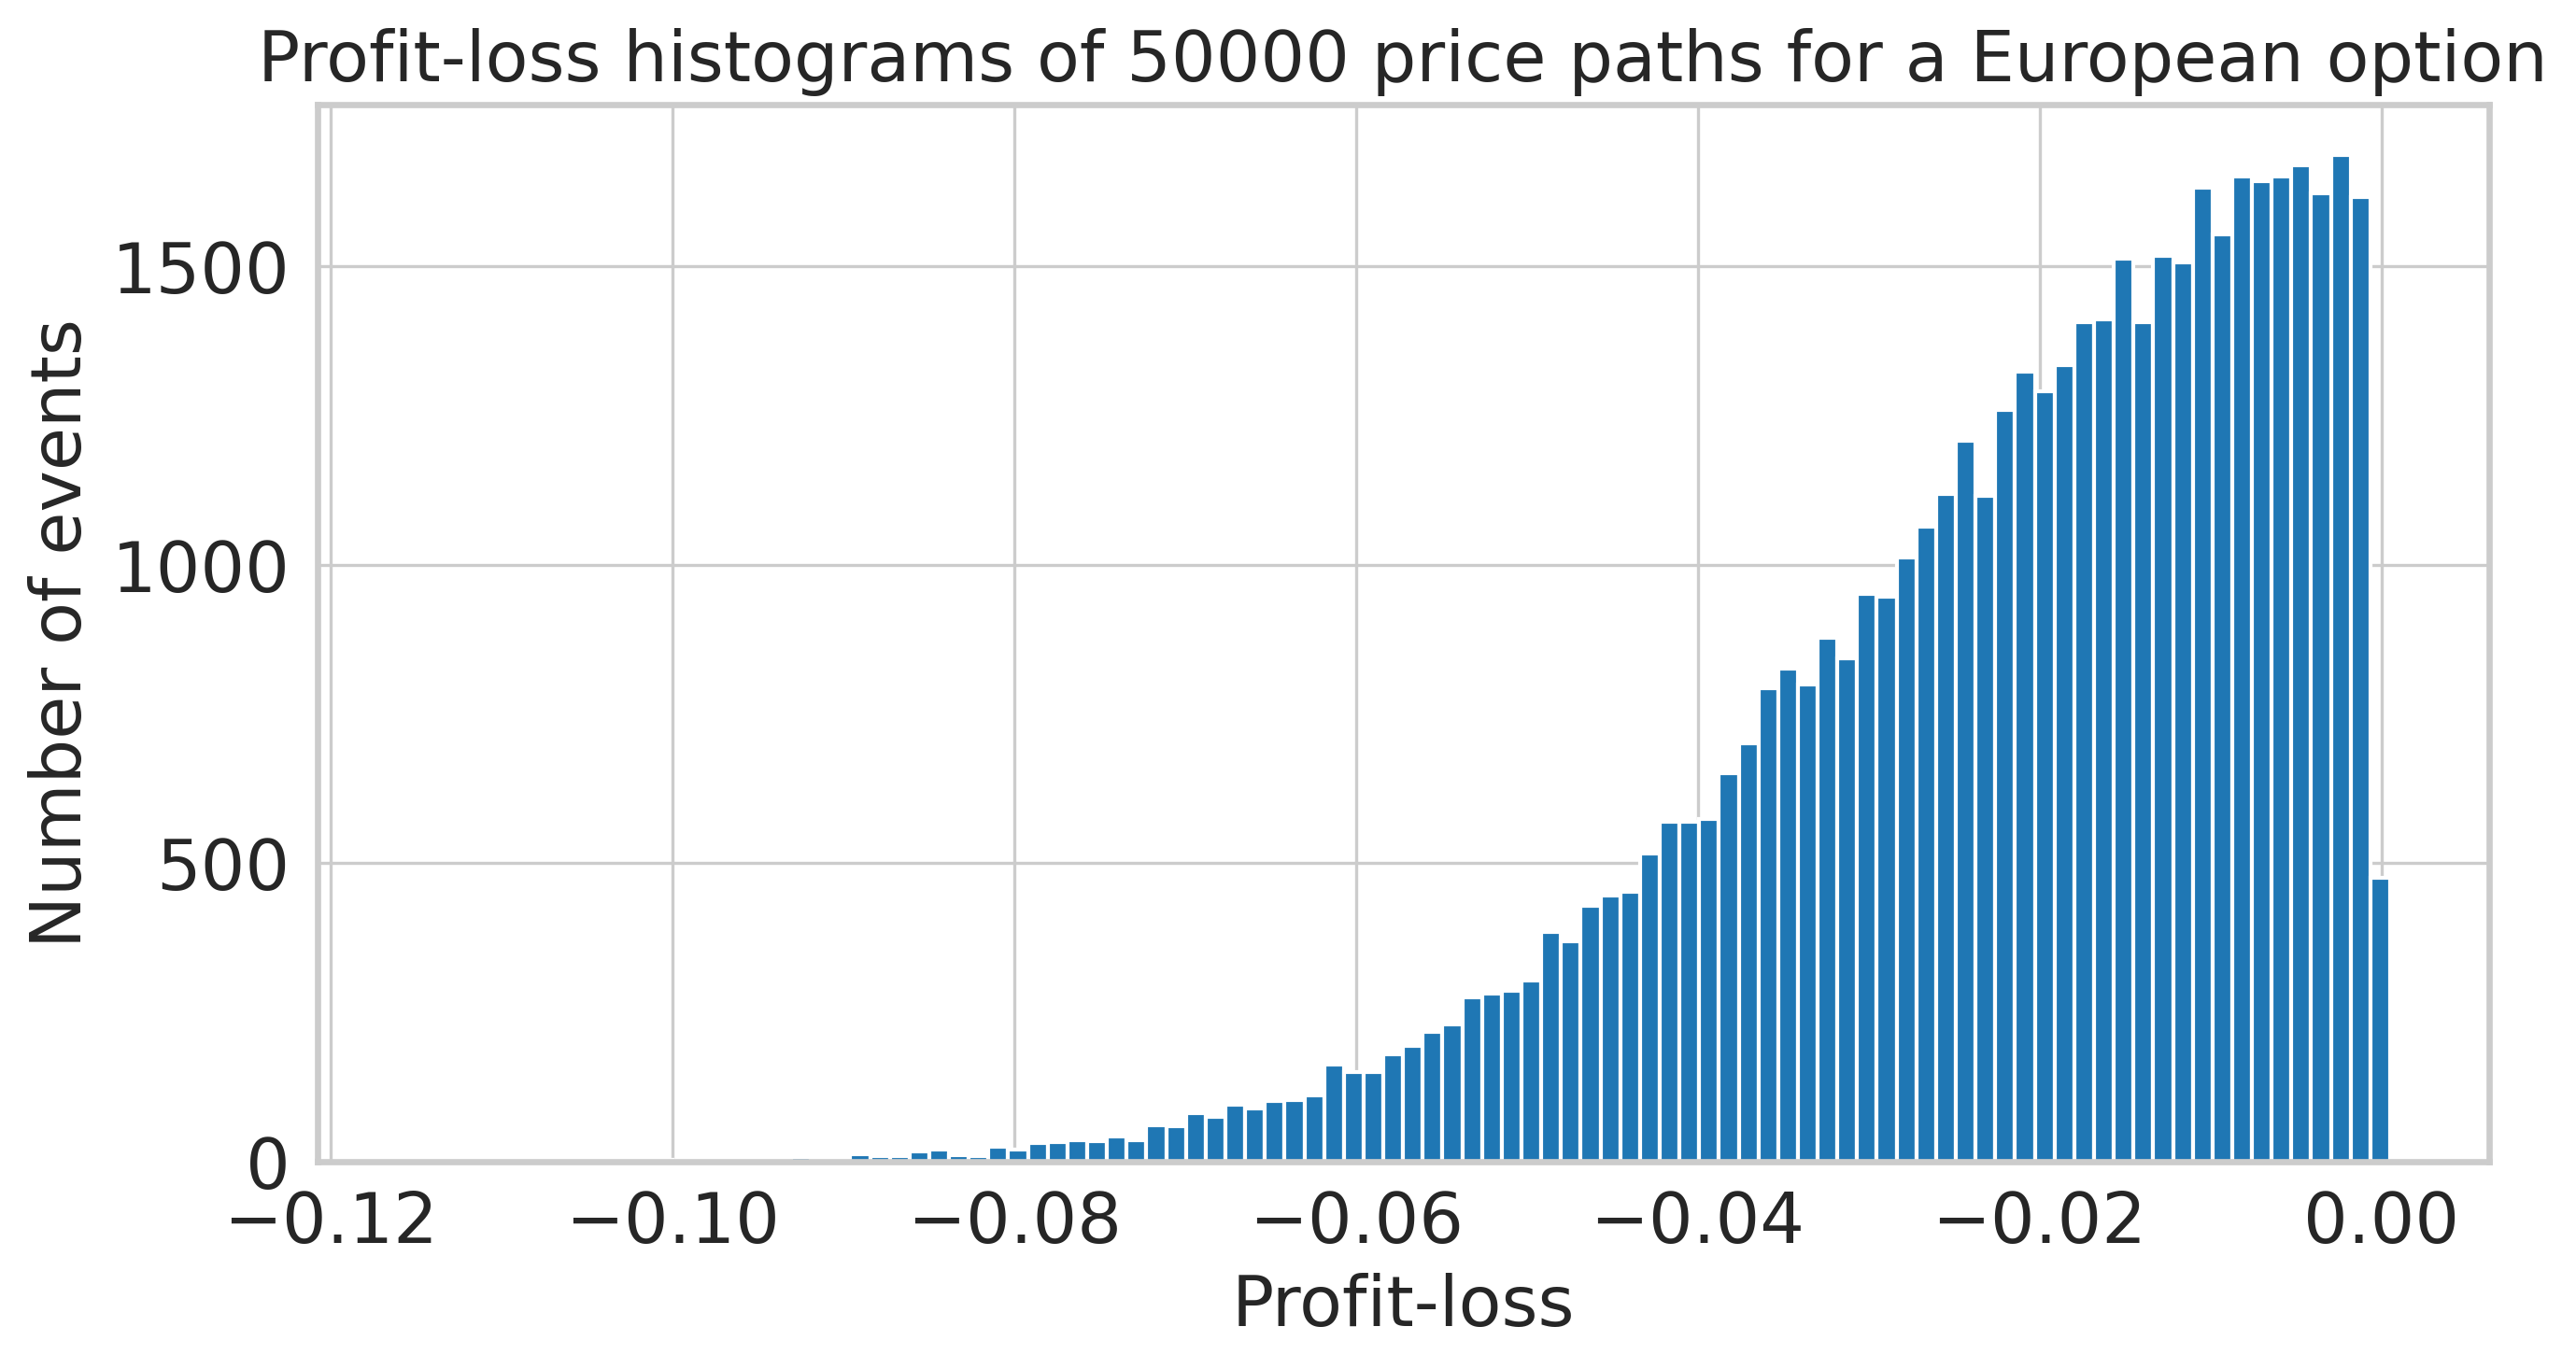

In [14]:
pnl = hedger.compute_pnl(deriv, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [15]:
price = hedger.price(deriv)
price

tensor(0.0229, device='cuda:0')

## More Examples

### Black-Scholes' Delta-Hedging Strategy

In [16]:
from pfhedge.nn import Hedger
from pfhedge.nn import BlackScholes

model = BlackScholes(deriv)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [17]:
hedger

Hedger(
  features=['log_moneyness', 'expiry_time', 'volatility'],
  (model): BSEuropeanOption()
  (criterion): EntropicRiskMeasure()
)

In [18]:
price = hedger.price(deriv)
price

tensor(0.0222, device='cuda:0')

### Whalley-Wilmott's Asymptotically Optimal Strategy for Small Costs

In [19]:
from pfhedge.nn import Hedger
from pfhedge.nn import WhalleyWilmott

model = WhalleyWilmott(deriv)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [20]:
price = hedger.price(deriv)
price

tensor(0.0220, device='cuda:0')

### Your Own Module

In [21]:
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module

from pfhedge.nn import BlackScholes, Clamp, MultiLayerPerceptron


class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()

        self.delta = BlackScholes(derivative)
        self.mlp = MultiLayerPerceptron(out_features=2)
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[:, [-1]]

        delta = self.delta(input[:, :-1]).reshape(-1, 1)
        width = self.mlp(input[:, :-1])

        min = delta - fn.leaky_relu(width[:, [0]])
        max = delta + fn.leaky_relu(width[:, [1]])

        return self.clamp(prev_hedge, min=min, max=max)

In [22]:
model = NoTransactionBandNet(deriv)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [23]:
history = hedger.fit(deriv, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=2.22060e-02: 100%|██████████| 200/200 [11:12<00:00,  3.36s/it]


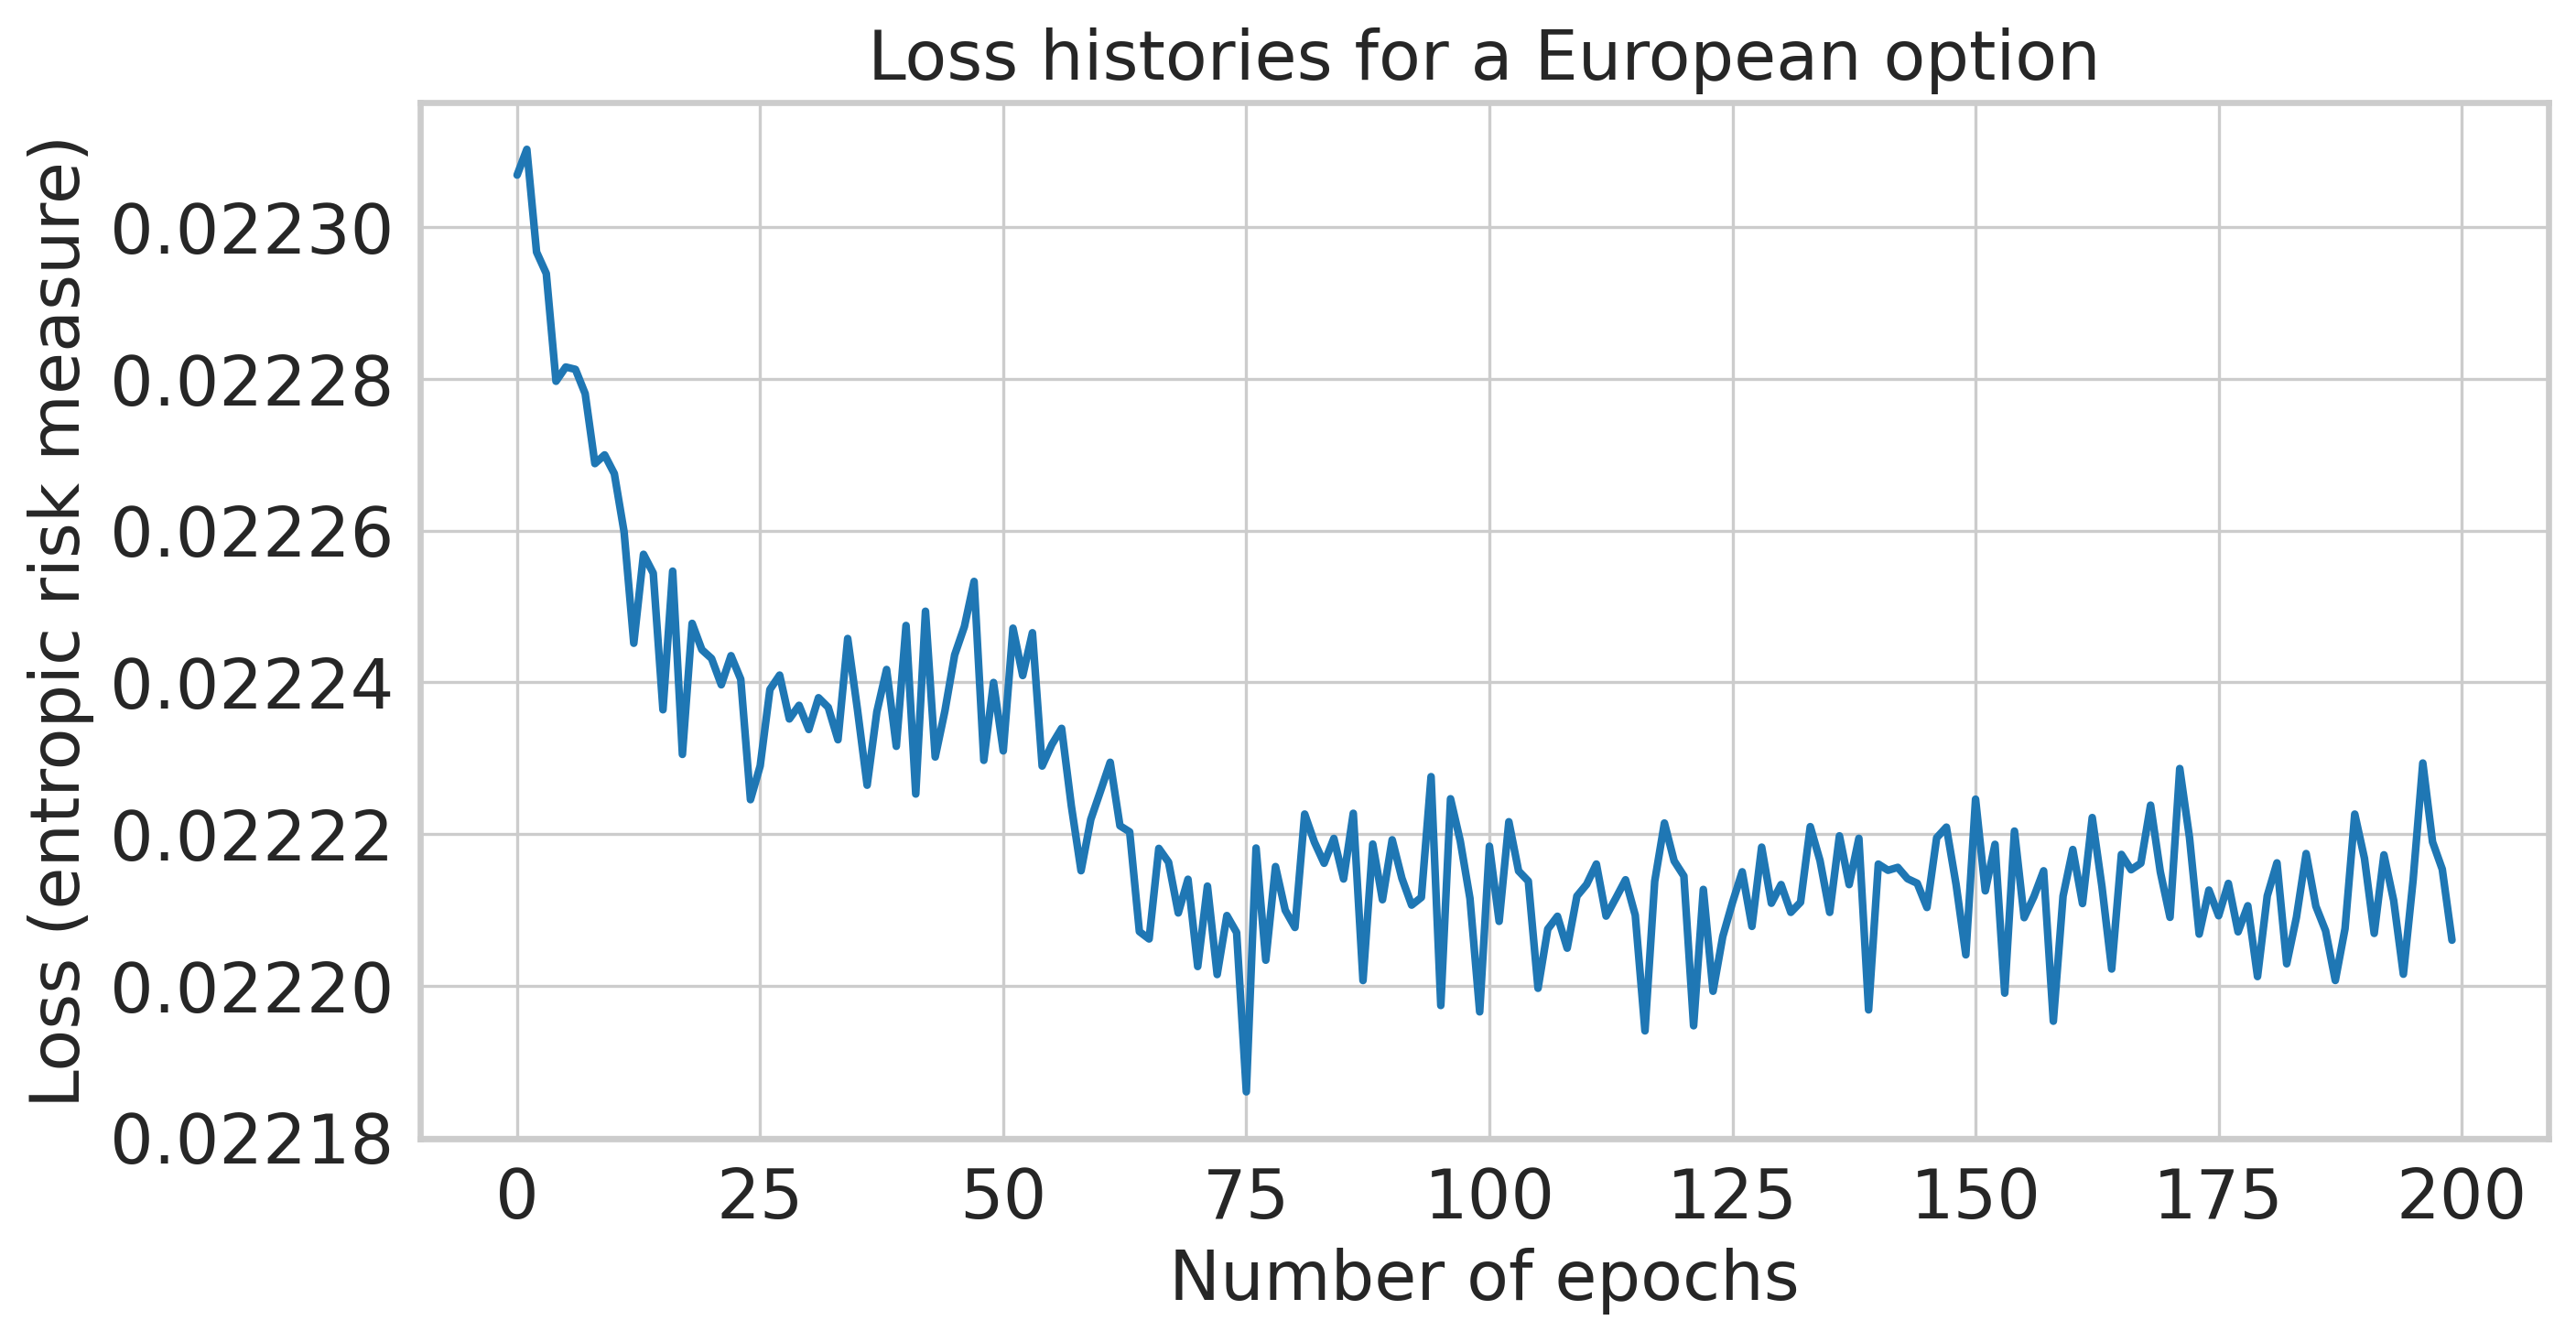

In [24]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

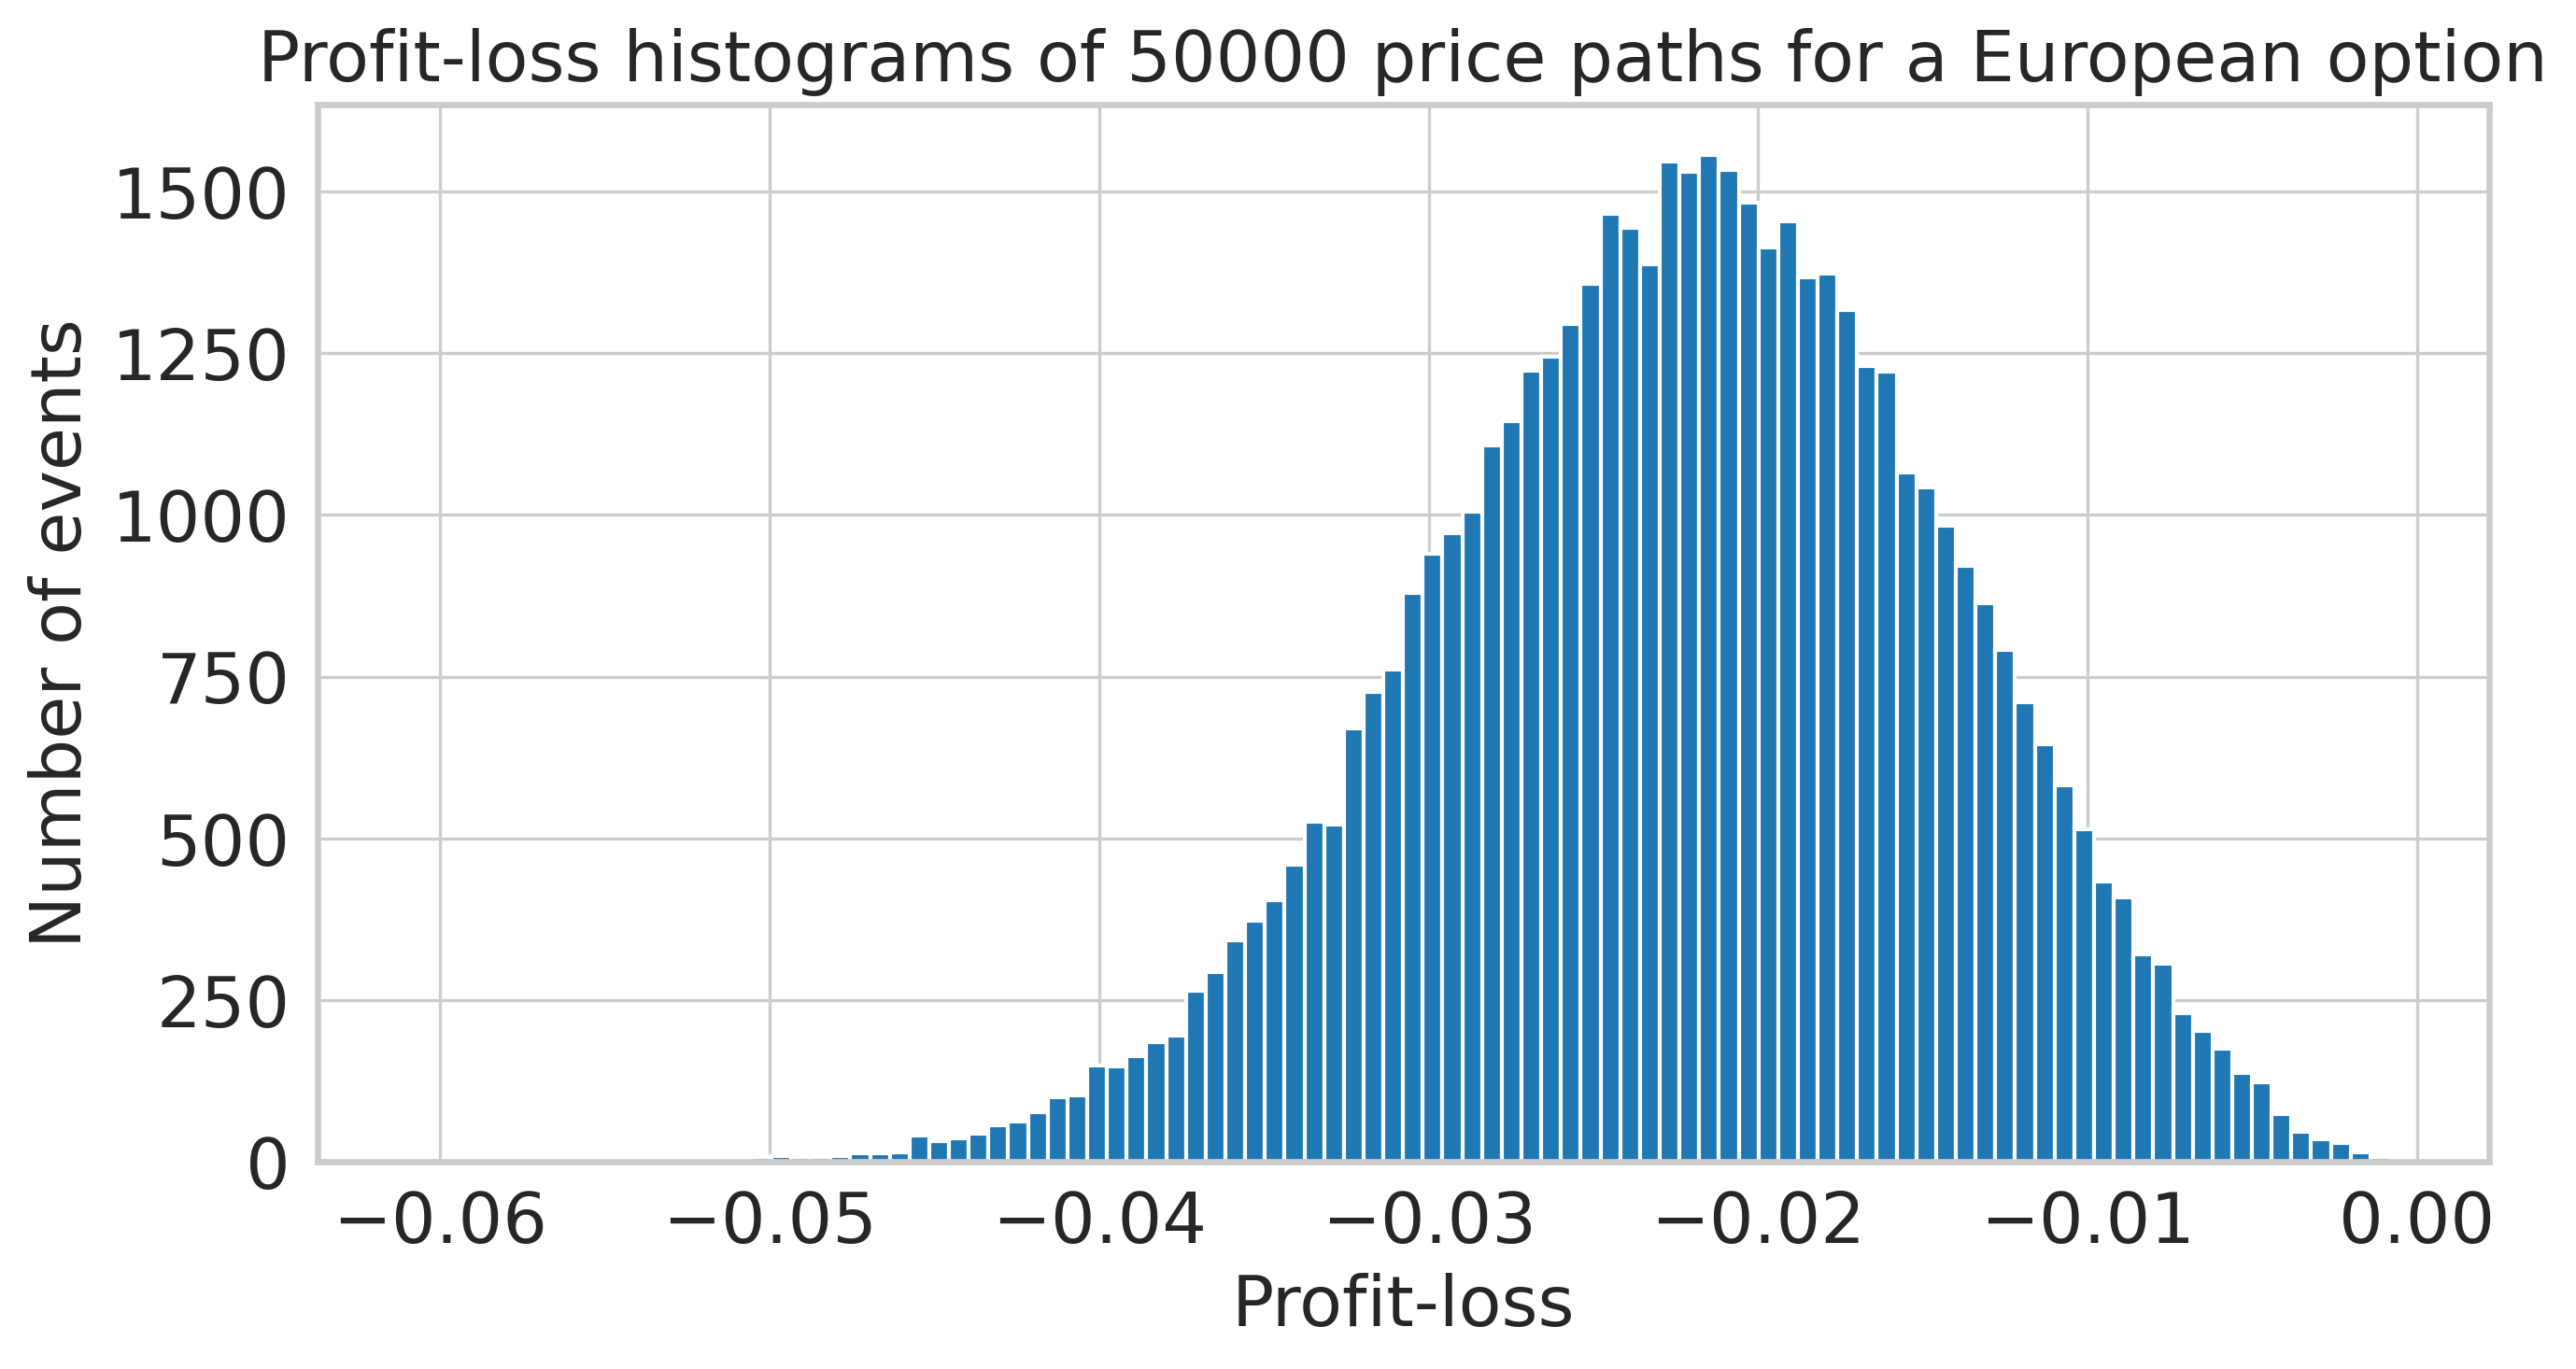

In [25]:
pnl = hedger.compute_pnl(deriv, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [26]:
price = hedger.price(deriv)
price

tensor(0.0224, device='cuda:0')

### Use Expected Shortfall as a Loss function

In [27]:
from pfhedge.nn import ExpectedShortfall

In [28]:
# Expected shortfall with the quantile level of 10%
expected_shortfall = ExpectedShortfall(0.1)

model = NoTransactionBandNet(deriv)
hedger = Hedger(model, inputs=model.inputs(), criterion=expected_shortfall).to(DEVICE)

In [29]:
history = hedger.fit(deriv, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=2.87042e-02: 100%|██████████| 200/200 [11:22<00:00,  3.41s/it]


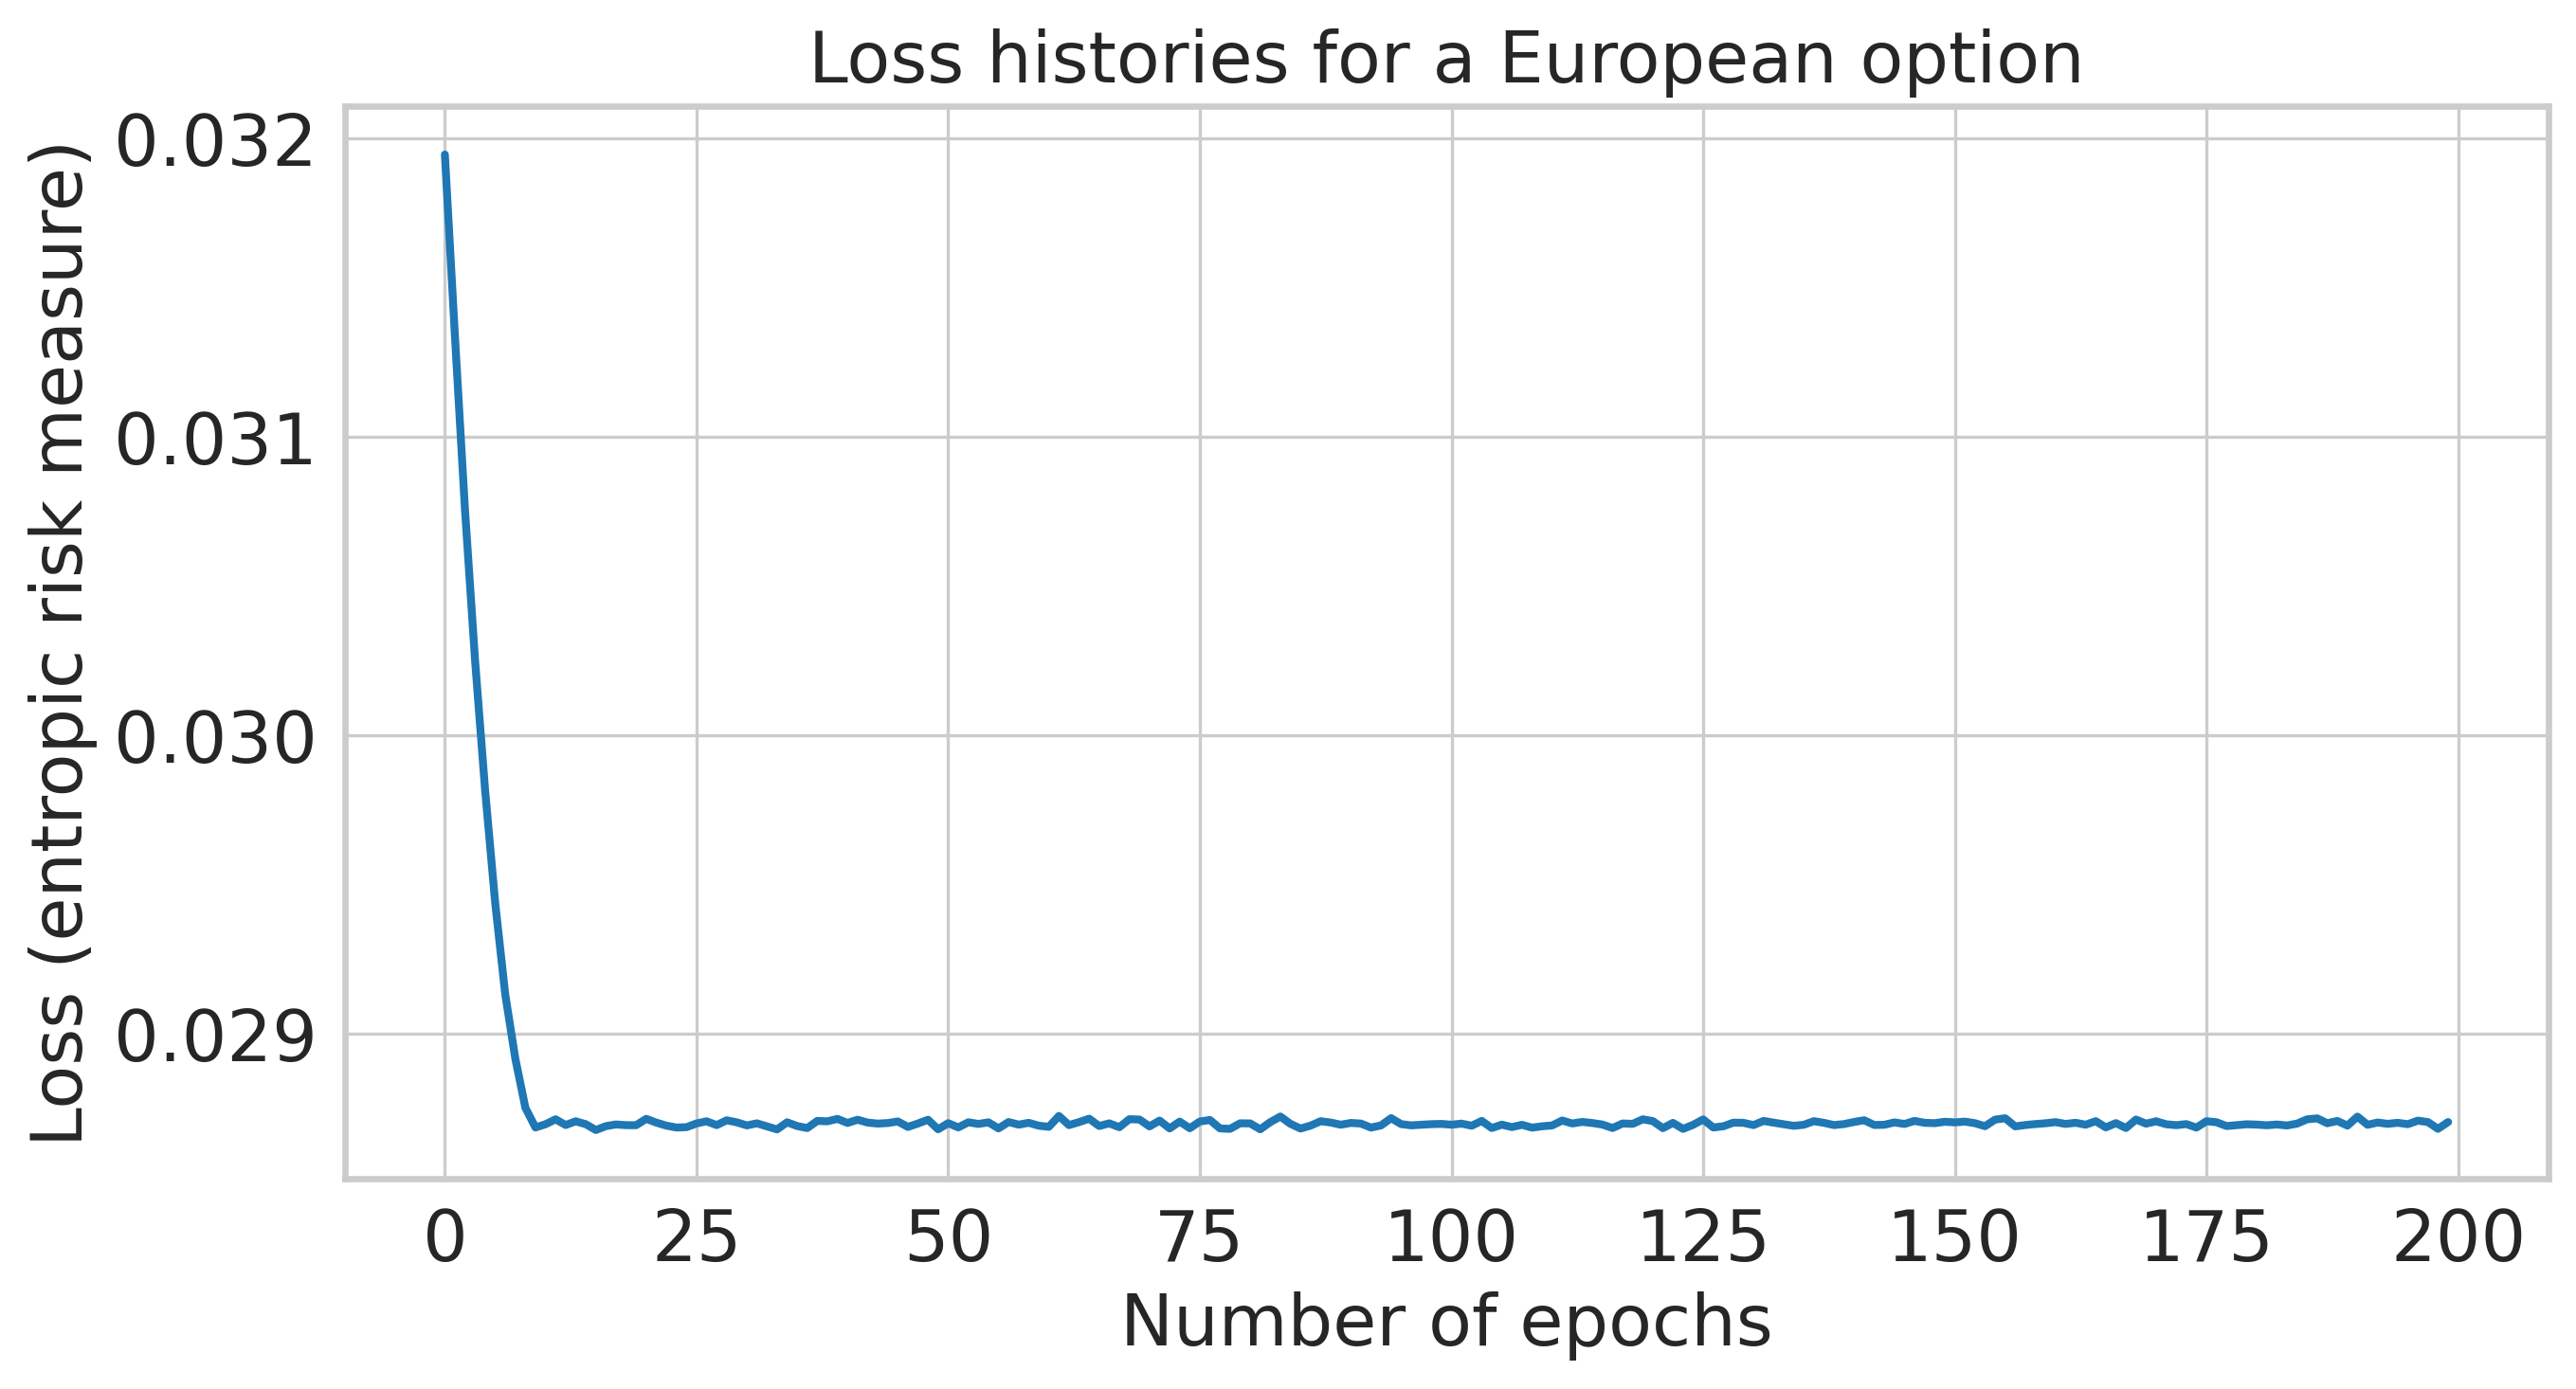

In [30]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

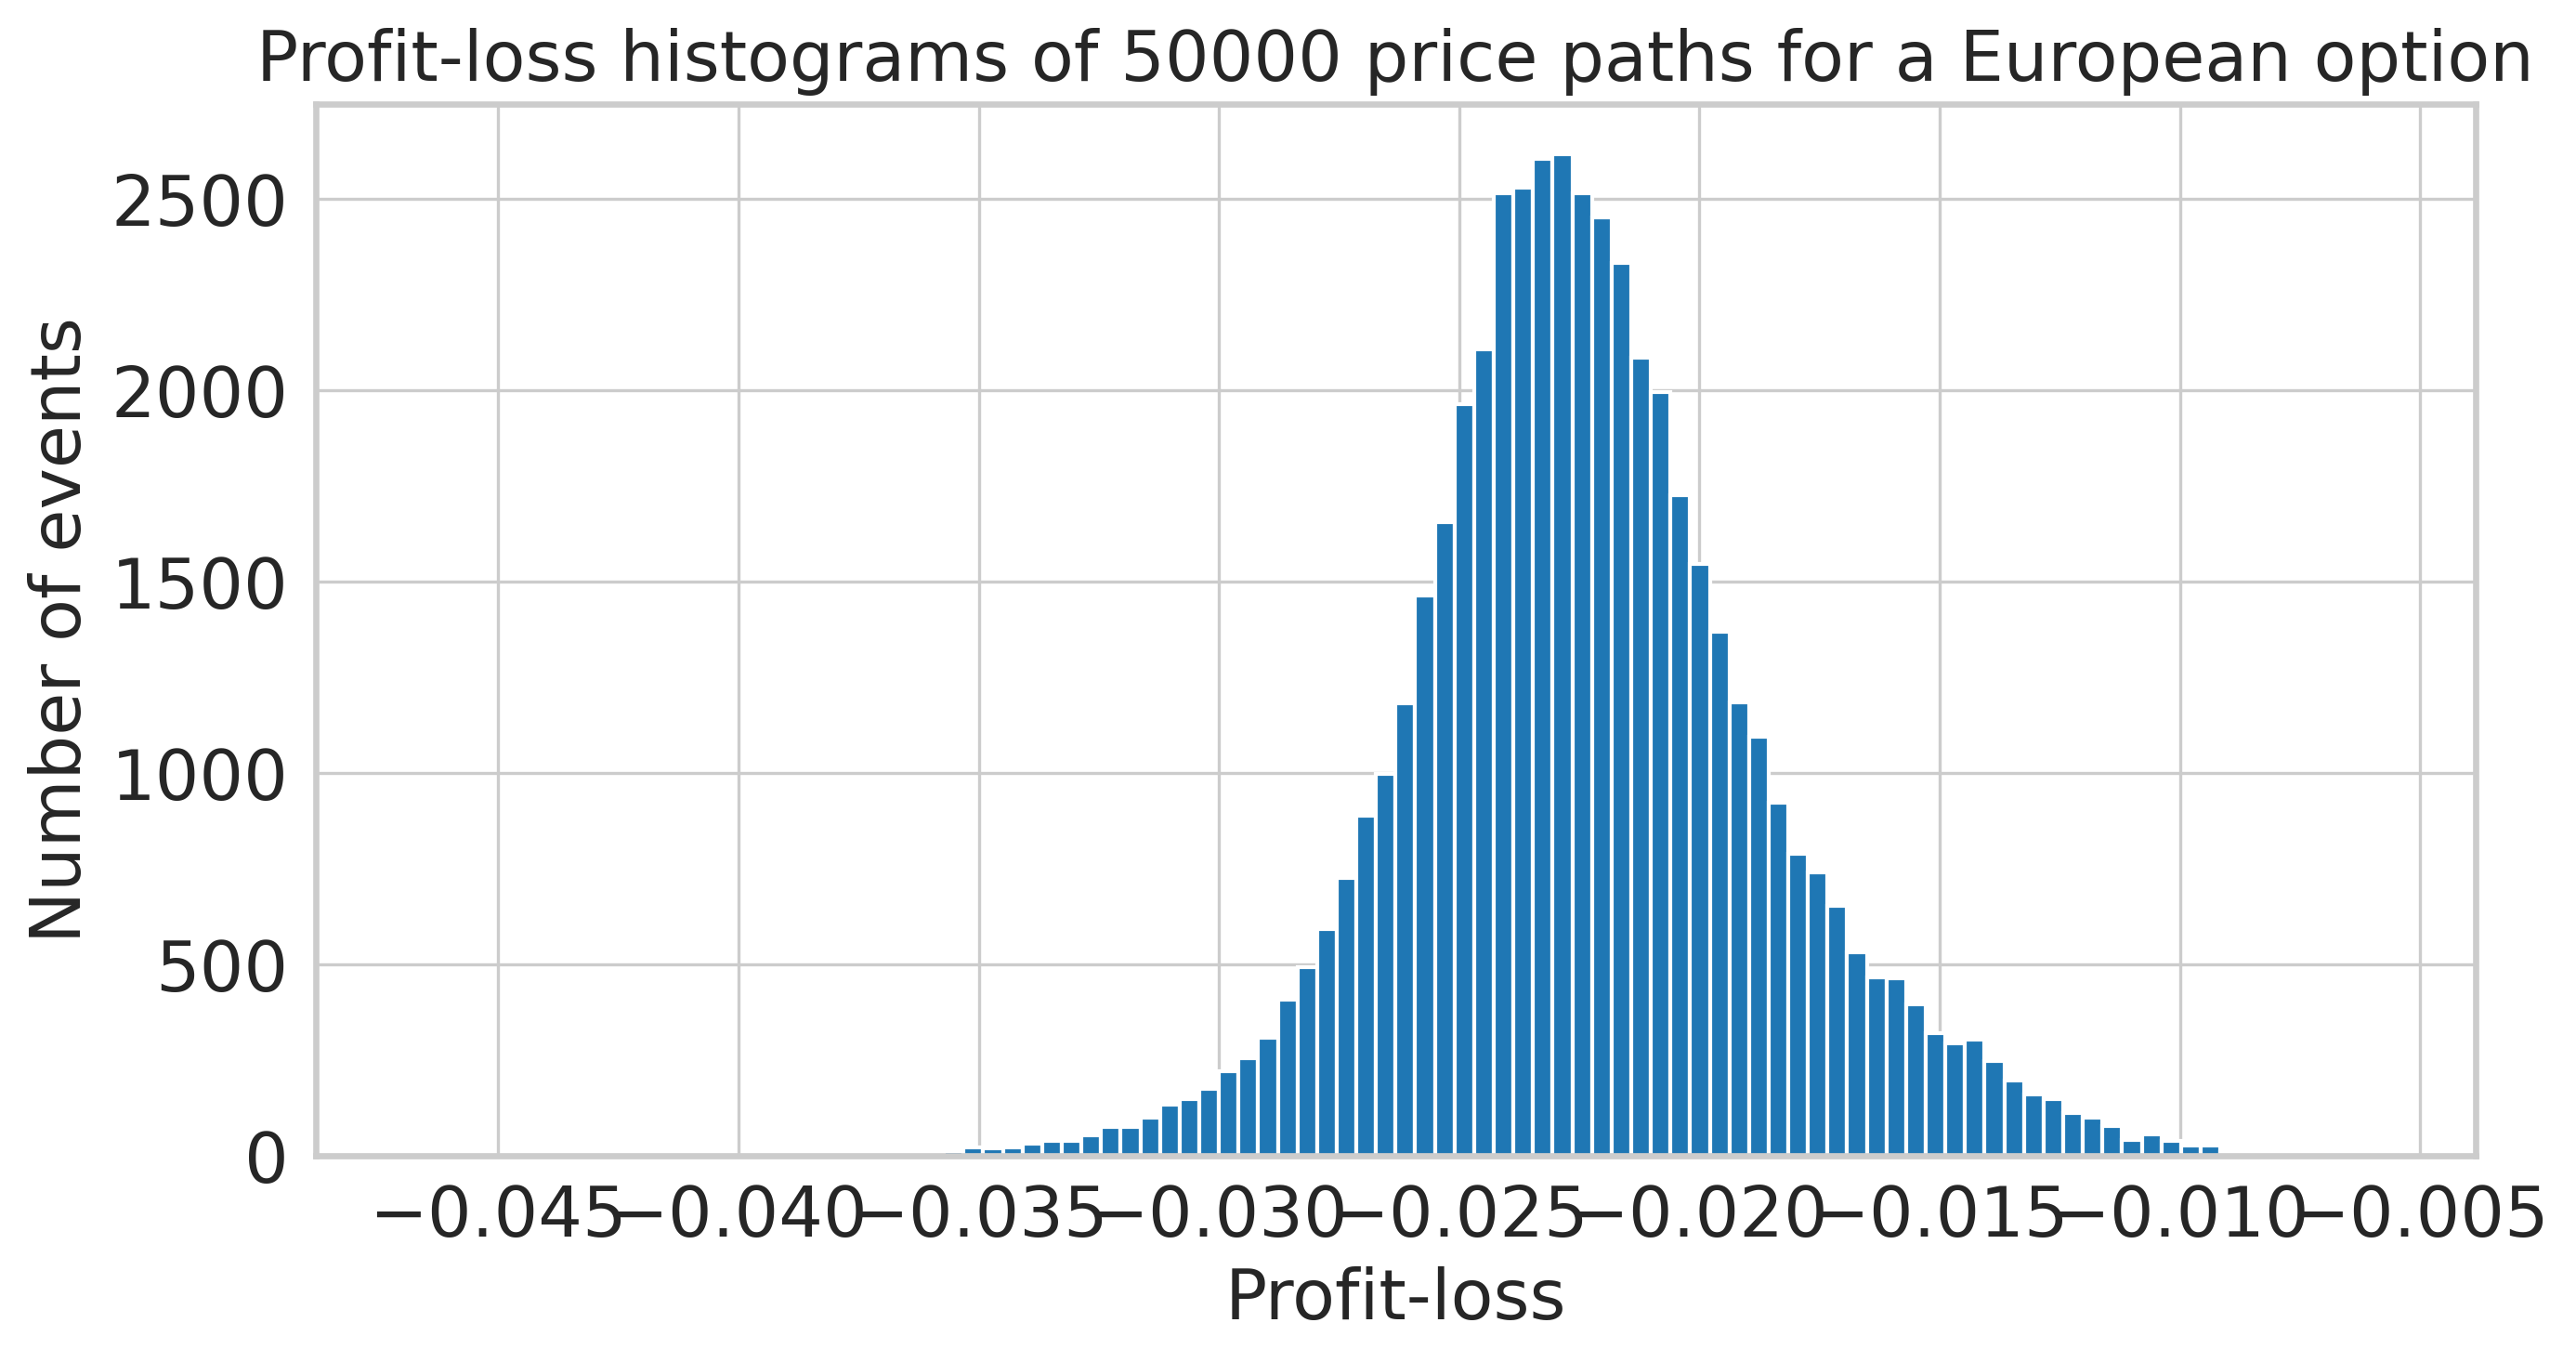

In [31]:
pnl = hedger.compute_pnl(deriv, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [32]:
price = hedger.price(deriv)
price

tensor(0.0291, device='cuda:0')